# Resume Analyzer

This application takes in two inputs -- a pdf resume/CV and a target role. It uses OpenAI LLM model to retrive top skills for the target role/industry/company, intelligently match it against the skills highlighted in resume, and generates a readiness score. Furthermore, it'll identify specific skills that are missing to guide the resume holder.  

In [10]:
import pandas as pd
from langgraph.graph import StateGraph, START, END
import fitz
from openai import OpenAI 
from typing import TypedDict, Dict, List, Any
import os
import json
import ast
from dotenv import load_dotenv

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")

In [4]:
# State
class ResState(TypedDict, total=False):
    target_role: str
    resume_path: str
    target_role_skills: Dict[str, List[str]]
    resume_skills: Dict[str, List[str]]
    readiness_score: float
    missing_skills: Dict[str, List[str]]
    matching_rate: Dict[str, float]
    recommendations: List[str]
    

In [5]:
# Helper functions

def extract_text_from_pdf(file_path: str) -> str:
    document = fitz.open(file_path)
    text = ""
    for page in document:
        text += page.get_text()
    document.close()
    return text


def extract_skills(text: str) -> dict:
    system_prompt = """You are an expert resume reader. Your goal is to extract top or most highlighted skills from resume texts. 
    Extract at most 20 hard skills and 20 soft skills from the provided text. Make sure to not repeat skills. 
    Ignore unrelated content like education, location, personal info. 
    Return the result as a valid Python dictionary with two keys: "hard_skills" and "soft_skills".
    Example output:
    {
    "hard_skills": ["SQL", "Python", "Excel"],
    "soft_skills": ["Communication", "Problem-solving"]
    }
    """

    client = OpenAI()
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0,
        messages=[
            {"role": "system", 
             "content": system_prompt},
            
            {"role": "user", 
             "content": f"Resume:\n{text}"}
        ]
    )

    output = response.choices[0].message.content
    skills_dict = ast.literal_eval(output)
    return skills_dict


def target_skills(role: str) -> dict:
    system_prompt = """You are an expert talent recruiter. Your goal is to identify top 10 hard skills and
    10 soft skills for the provided role that are currently in demand. Make sure to not repeat skills. 
    Return the result as a valid Python dictionary with two keys: "hard_skills" and "soft_skills".
    Example output:
    {
    "hard_skills": ["SQL", "Python", "Excel"],
    "soft_skills": ["Communication", "Problem-solving"]
    }
    """

    client = OpenAI()
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.2,
        messages=[
            {"role": "system", 
             "content": system_prompt},
            
            {"role": "user", 
             "content": f"Target role:\n{role}"}
        ]
    )

    output = response.choices[0].message.content
    target_skills_dict = ast.literal_eval(output)
    return target_skills_dict

def evaluator(resume_hard:list, resume_soft:list, target_hard:list, target_soft:list) -> dict:
    system_prompt = """You are a talent recruiter skilled in matching resume skills with job requirements.

                        You will receive four Python-style dictionaries:
                        1. resume_hard: list of hard skills from the resume
                        2. resume_soft: list of soft skills from the resume
                        3. target_hard: list of required hard skills for the role
                        4. target_soft: list of required soft skills for the role

                        Your task is to evaluate skill match quality by: 
                        1. Comparing resume_hard to target_hard to identify missing skills and calculate a hard skill match percentage.
                        2. Comparing resume_soft to target_soft to identify missing skills and calculating a soft skill match percentage.
                        
                        Use smart matching, not just exact string equality. Match skills by meaning, synonyms, and related concepts. 
                        
                        Use this formula for each match percentage:
                        (matching_skills / target_skills) * 100

                        If target_hard or target_soft is empty, return 0.0 as the corresponding match score.
                        
                        Return a Python-style dictionary using these keys and value formats:
                        - hard_skill_match: a float value between 0 and 1 (rounded to 2 decimal places)
                        - missing_hard_skills: a list of string values of missing hard skills
                        - soft_skill_match: a float value between 0 and 1 (rounded to 2 decimal places)
                        - soft_hard_skills: a list of string values of missing soft skills
                        
                        Example output:
                        {
                          "hard_skill_match": 0.85,
                          "missing_hard_skils": ['SQL','Database Management'],
                          "soft_skill_match": 0.67,
                          "missing_soft_skils": ['Collaboration','Critical Thinking'],
                        }
                        Do not include any explanation. Just return the dictionary.
                        """

    user_prompt = f"""Here are the skill dictionaries:
                    resume_hard: {resume_hard}
                    resume_soft: {resume_soft}
                    target_hard: {target_hard}
                    target_soft: {target_soft}"""

    client = OpenAI()
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.7,
        messages=[
            {"role": "system", 
             "content": system_prompt},
            
            {"role": "user", 
             "content": user_prompt}
        ]
    )

    output = response.choices[0].message.content
    # rates_dict = ast.literal_eval(output)
    return output

In [6]:
# Nodes
def resume_reader(state: ResState) -> ResState:
    resume_text = extract_text_from_pdf(state['resume_path'])
    state['resume_skills'] = extract_skills(resume_text)
    return state


def target_role_researcher(state: ResState) -> ResState:
    state['target_role_skills'] = target_skills(state['target_role'])
    return state


def skills_matcher(state: ResState) -> ResState:
    raw_response = evaluator(state['resume_skills']['hard_skills'],
                                state['resume_skills']['soft_skills'],
                                state['target_role_skills']['hard_skills'],
                                state['target_role_skills']['soft_skills'])

    formatted_dict = json.loads(raw_response)
    hard_score = formatted_dict['hard_skill_match']
    soft_score = formatted_dict['soft_skill_match']
    weighted = 0.7 * hard_score + 0.3 * soft_score # The weighting of hard and soft skills can be adjusted as per business needs. 
    
    state['readiness_score'] = round(weighted, 2)
    state['missing_skills'] = (formatted_dict.get("missing_hard_skills", []) +
                           formatted_dict.get("missing_soft_skills", []))

    return state


def print_results(state: ResState) -> ResState:
    print(f'The readiness score of the provided resume for the {state['target_role']} role is:', state['readiness_score'])
    print('Missing skills', state['missing_skills'])


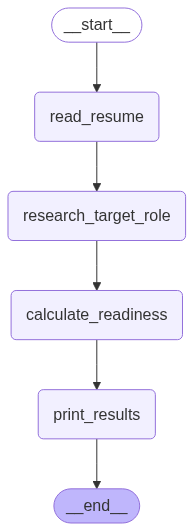

In [7]:
# Graph
ra_graph = StateGraph(ResState)

ra_graph.add_node("read_resume", resume_reader)
ra_graph.add_node("research_target_role", target_role_researcher)
ra_graph.add_node("calculate_readiness", skills_matcher)
ra_graph.add_node("print_results", print_results)

ra_graph.add_edge(START, "read_resume")
ra_graph.add_edge("read_resume", "research_target_role")
ra_graph.add_edge("research_target_role", "calculate_readiness")
ra_graph.add_edge("calculate_readiness", "print_results")
ra_graph.add_edge("print_results", END)

compiled_graph = ra_graph.compile()
compiled_graph

In [11]:
#Invoke Graph

response = compiled_graph.invoke({
    "target_role": "Data Analyst at Google",
    "resume_path": "resume_sample.pdf"
})

The readiness score of the provided resume for the Data Analyst at Google role is: 0.65
Missing skills ['Power BI', 'MySQL', 'Data Wrangling', 'Data Modeling', 'DAX', 'ETL', 'Stored Procedures', 'Data Validation', 'Data Aggregation', 'Data Exploration', 'Data Loading', 'Project Management', 'Kanban', 'UTM Parameters', 'Stakeholder Management', 'Domain Knowledge', 'Decision-making', 'Leadership', 'Detail-oriented', 'Strategic Planning', 'Client Interaction', 'Cross-functional Collaboration', 'Data-driven Decision Making', 'User Acceptance Testing', 'Feedback Incorporation']
